# This notebook demostrates the augmentation of stellar grid models with Gaussian Process Regression (GPR) models.

# workflow: 

S1: Grid computation/selection: Given a star or a star sample with known observations, we could derive the ranges of inputs parameters. Assuming we are working on the Lund's star sample. We use the scalling relation to derive the mass range of the sample, which is from 0.9 - 1.1 solar mass. We could also know their evolving stages (main-sequence dwarf or early subgiants) by inspecting their locations on the HR diagram. Their metallicities are in a range of [Fe/H] = -0.3 -- 0.3 dex which are from the spectroscopy. Their helium fraction and mixing-length parameter are not unknow. We then use a typical ranges for these two parameters. 

S2: Select training data: Training data should cover the whole parameter sapce and we also need to highly-weighted the areas presenting sharp changes (if there are any).

S3: kernel selection and training data validation: we need a kernel which has proper flexibility to fit the feature of evolutionary tracks. A proper kernel should be able to well reproduece all training data. There could be multiple kernels. 

S4: test data validation: All good kernels will be validated with test data, which contents model data on the grid of training data (but not used for training) as well as model data which are off-grid. If the validation results are not good, go back to S2. There could be a couple iterations from S2 to S4.

S5: When the best model is found, use the validation results to estimate systematical uncertainty (could be another GP model.)



In [ ]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [ ]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None,valipath = None, savepath = None):
        self._datapath = datapath
        self._valipath = valipath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')

        if not os.path.exists(valipath):
            raise Warning(f'valipath:' + valipath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Validation path is set as' + self._valipath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, path = None,
                           condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None):
        if path == None:
            raise Warning(f'$path$ must be given')

        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        #if (validation_frac == None):
        #    warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
        #    validation_frac = 0.2
    
        all_files = glob.glob(path + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        #print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
        
        df = []    
        df = pd.concat(df1, ignore_index=True)
        
        #random_state = 1

        #if (len(df['type'])*(1 - validation_frac) >= 10000):
        #    train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        #else:
        #    train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        #df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        #m = re.search('yinit(.+?)MLT', filename)
        #if m:
        #    found = m.group(1)
        
        #one_track['initial_Yinit'] = float(found)                
        #get rid of the pre-MS
        #one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        #one_track['type'] = 'data'
        one_track['hrgradient'] = ((np.gradient(one_track['effective_T']/5777.0))**2.0 
                                 + (np.gradient(one_track['log_g']/4.44))**2.0
                                  )**0.5
        
        one_track['fagegradient'] = np.gradient(one_track['frac_age'])
      
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
    
    ######################GP models##################
    
    def kernel_bank(self, kname,input_dim):
        
        ard = True
        
        if kname == 'RBF': 
            k = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
        elif kname == 'EXP': 
            k = GPy.kern.Exponential(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
        elif kname == 'MLP': 
            k = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
        elif kname == 'MLP+RBF':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = ard)
            k = k1+k2
        elif kname == 'MLP+MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'MLP*MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=ard)
            k = k1*k2
        elif kname == 'MLP+EXP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.Exponential(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'MLP+RQ':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = ard)
            k2 = GPy.kern.RatQuad(input_dim = input_dim, ARD=ard)
            k = k1+k2
        elif kname == 'RQ':
            k = GPy.kern.RatQuad(input_dim = input_dim, ARD=ard)
        elif kname == 'Mat32':
            k = GPy.kern.Matern32(input_dim = input_dim, ARD=ard)
        else: 
            k = None
        return k

    
    def gp_a_dataframe(self, df = None, xcolumns = None, ycolumns = None, kname = None):
        
        start_time = time.time()
        nx = len(xcolumns)
        ny = len(ycolumns)
        #if (ny != 1):
        #    raise Warning(f'y must be 1 dimession!')

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        gpm = GPy.models.GPRegression(xx,yy,kernel)
        gpm.optimize()
        print("--- %s seconds ---" % (time.time() - start_time))
        return gpm
    
    ###################################################
    def load_a_gpm(self, df = None, npy = None, xcolumns = None, ycolumns = None, kname = None):
        
        nx = len(xcolumns)
        ny = len(ycolumns)

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
        m_load.update_model(False) # do not call the underlying expensive algebra on load
        m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
        m_load[:] = np.load(npy) # Load the parameters
        m_load.update_model(True) # Call the algebra only once
        print(m_load)
        return m_load

    
    ######################inspecting model######################
    def inspect_gpm_on_1d(self, gpm = None, df = None, xcolumns = None, ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        gpy = gpm.predict(xx)
        
        for name in xcolumns:
            fig, ax = plt.subplots(1, figsize=(6,5))
            ax.scatter(df[name], df[ycolumns],s = 10, c = 'k')
            ax.scatter(df[name], gpy[0].reshape(ndf,), s = 5, c = 'r')
            ax.set_xlabel(name)
            ax.set_ylabel(ycolumns)
        return
    
        #########################
        #####################
    
    ####
    def inspect_gpm_on_2d(self, gpm = None, df = None, xcolumns = None, ycolumns = None, xplots = None,
                          randomshift = None, shiftfactor = None, title = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
            
        if shiftfactor == None: shiftfactor = 0.01
        if randomshift == True: xx = xx + shiftfactor*xx
        
        gpy = gpm.predict(xx)
        
        nc = len(xplots)
        if nc < 2: raise Warning(f'xplots must be >=2 dimession!')
        
        for i in range(nc):
            name1 = xplots[i]
            for i2 in range(nc-i-1):
                name2 = xplots[i+i2+1]
                print(name1, name2)
                fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
                cp = ax1.scatter(df[name1], df[name2], c = (df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]],s = 2)
                #ax.scatter(df[name1], df[name2], c = gpy[0].reshape(ndf,), s = 15)
                ax1.set_xlabel(name1)
                ax1.set_ylabel(name2)
                colorbar = plt.colorbar(cp)
                colorbar.set_label(ycolumns[0] + '(Grid - GP)/Grid')
                ax2.hist((df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]], bins = 50)
                if title != None: ax1.set_title(title)
        return

    ######################sampling##############################
    def guassian_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        y = 1.0/(sigma*(2.0*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.0)
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def uniform_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        data_array = (np.random.choice(n,n)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def linear_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def age_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x**2
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def mle(self, model, obs, obs_e):
        lk = 1.0/ (2.0*3.14159*obs_e**2.0)**(0.5) * np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
        return lk
    
    def sample_results(self, df = None, lkname = None, f = None):
        df[lkname] = df[lkname]/np.sum(df[lkname])
        newdf = df.copy()
        for index, row in df.iterrows():
            copies = int(f*row[lkname])
            for i in range(copies):
                newdf = newdf.append(row,ignore_index=True)
        newdf.drop(index = df.index,inplace=True)
        return newdf
    
    def sample_cmd(self, gpm = None, df = None, prediction = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ccolumns = None, mcolumns = None):
        nx = len(xcolumns)
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.scatter(df[ccolumns], df[mcolumns],c = df[prediction], s = 5)
            
        ndf = len(df)
        
        df2 = df.copy()
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        
        ax2.scatter(df2[ccolumns],df2[mcolumns],c = gpp[0].reshape(ndf,), s = 5)
        ax1.set_xlabel(ccolumns)
        ax1.set_ylabel(mcolumns)
        ax1.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax2.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax1.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax2.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax1.set_title('Model Grid')
        ax2.set_xlabel(ccolumns)
        ax2.set_title('GP predictions')
        return 
    
    def sample_with_df(self, n = None, df = None, gpm = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        
        df2 = df.copy()
        if (len(df2) < n):
            for i in range(100):
                df2 = pd.concat([df2, df])
                if len(df2)>n: break
        
        df2.index = range(len(df2))
        
        ndf = len(df2)
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        df2[ycolumns] = gpp[0]
        df2['gp_var'] = gpp[1].reshape(ndf,)
        
        #for yname in ycolumns:
        #    index = ycolumns.index(yname)
        #    gpp = gpm[index].predict(xx)
        #    df2[yname] = gpp[0].reshape(ndf,)
        #    df2[yname + '_var'] = gpp[1].reshape(ndf,)
        return df2



In [31]:
xcolumns = ['initial_mass','frac_age', 'initial_zx', 'initial_Yinit', 'initial_MLT']
ycolumns = ['effective_T'] #,'log_g','radius', 'star_age','star_zx', 'delta_nu_fit']
xshifts = [0.0,0.0,0.0,0.0,0.0]

ntraining = 10000
nvalidating = 20000
nresidual = 50000

In [32]:
datadr = '/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/'
savedr = '/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/' + ycolumns[0] + '/'
validr = '/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/'
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr, valipath = validr)

Data path is set as/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/
Validation path is set as/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/
Save path is set as/Users/litz/Documents/GitHub/GPGrid/paper_used/5D_fun_to_obs/effective_T/


# section 3.2 3D-inputs GPR models: p = f(mass, frac_age, initial feh)

In [33]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [1.7,2.3],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]

#df = gmk.get_data_of_a_grid(path = gmk._datapath,
#                               condition = '*.csv', number = None,
#                               columns = columns,
#                               ranges = ranges, 
#                               normalization = normalization)
#df['initial_zx'] = 10**df['initial_feh']*0.0181
#df['star_zx'] = 10**df['star_feh']*0.0181
#df['frac_age'] = df['frac_age']

#df.to_csv(savedr + 'df.csv')

df = pd.read_csv(datadr + 'df_5d.csv')

#dfvon = df.sample(n = nvalidating, weights = 'hrgradient', random_state = 78)
#dfvon.to_csv(savedr + 'dfvon.csv')
df

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,frac_age,ms_age,effective_T,log_g,radius,star_feh,delta_nu_fit,hrgradient,fagegradient,initial_zx,star_zx
0,0,1,0.820,0.32,0.35,2.5,0.237170,0.010967,17.109211,4977.073602,4.636168,0.720721,0.348426,200.051403,0.000227,0.001571,0.040521,0.040374
1,1,1,0.820,0.32,0.35,2.5,0.274239,0.012681,17.109211,4978.098870,4.635436,0.721329,0.348144,199.796682,0.000259,0.001886,0.040521,0.040348
2,2,1,0.820,0.32,0.35,2.5,0.318723,0.014738,17.109211,4979.354077,4.634675,0.721962,0.347807,199.532401,0.000296,0.002263,0.040521,0.040317
3,3,1,0.820,0.32,0.35,2.5,0.372103,0.017207,17.109211,4980.853442,4.633871,0.722630,0.347402,199.254386,0.000340,0.002715,0.040521,0.040279
4,4,1,0.820,0.32,0.35,2.5,0.436159,0.020169,17.109211,4982.627232,4.633009,0.723348,0.346918,198.957193,0.000338,0.002801,0.040521,0.040234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688945,8688945,2,1.115,0.27,-0.45,2.2,4.554941,0.997882,3.310997,5405.707240,3.613012,2.724297,-0.460637,31.874636,0.001257,0.000438,0.006422,0.006267
8688946,8688946,2,1.115,0.27,-0.45,2.2,4.556924,0.998317,3.310997,5399.604131,3.610154,2.733264,-0.460416,31.710041,0.001356,0.000478,0.006422,0.006270
8688947,8688947,2,1.115,0.27,-0.45,2.2,4.559302,0.998838,3.310997,5392.431447,3.606616,2.744406,-0.460305,31.504866,0.001600,0.000573,0.006422,0.006272
8688948,8688948,2,1.115,0.27,-0.45,2.2,4.562157,0.999463,3.310997,5384.193688,3.602298,2.758068,-0.460044,31.259449,0.001592,0.000581,0.006422,0.006275


In [34]:
columns = ['evol_stage',
           'initial_mass',
           'initial_Yinit',
           'initial_feh',
           'initial_MLT',
           'star_age',
           'frac_age',
           'ms_age',
           'effective_T',
           'log_g',
           'radius',
           'star_feh',
           'delta_nu_fit',
           'nu_max']
ranges = [[1,100],
          [0.0,2.0], 
          [0.0,2.0],
          [-0.5,0.5],
          [1.7,2.3],
          [-1.0e99, 1.0e99],
          [0.01,2.00], 
          [-1.0e99,1.0e99],
          [-999999,999999],
          [3.8000,999999.0],#[(obs_logg - 5.0*obs_logg_e), (obs_logg + 5.0*obs_logg_e)],
          [-9999,9999],
          [-99999,999999],
          [-9999.0,999999],
          [-999999,999999]
         ]

normalization = [-9999,-9999, -9999, -9999, -9999,-9999, -9999, -9999,
                 -9999, -9999, -9999,-9999, 
                 -9999,-9999]
#dfv = gmk.get_data_of_a_grid(path = gmk._valipath,
#                                condition = '*.csv', number = None,
#                                columns = columns,
#                                ranges = ranges, 
#                                normalization = normalization)
#dfv['initial_zx'] = 10**dfv['initial_feh']*0.0181
#dfv['star_zx'] = 10**dfv['star_feh']*0.0181
#dfv['frac_age'] = dfv['frac_age']

#dfv0 = dfv.copy()

#dfv = dfv.sample(n = nvalidating, weights = 'hrgradient', random_state = 1000)
#dfv.index = range(len(dfv))
#dfv.to_csv(savedr + 'dfv_.csv')

dfv = pd.read_csv(datadr + 'dfv_5d.csv')
dfv = dfv[(dfv['initial_mass']>=0.81) & (dfv['initial_mass']<=1.19)]
dfv = dfv[dfv['initial_MLT']>=1.7]
dfv = dfv[dfv['initial_Yinit']>=0.24]
dfv = dfv[dfv['initial_Yinit']<=0.32]
dfv.index = range(len(dfv))
dfv

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,frac_age,ms_age,effective_T,log_g,radius,star_feh,delta_nu_fit,hrgradient,fagegradient,initial_zx,star_zx
0,0,2,1.160905,0.293058,0.152429,2.053150,5.157191,0.858736,4.610980,5939.062606,4.007436,1.767801,0.058163,63.115560,0.001341,0.003603,0.025710,0.020694
1,1,2,0.982776,0.243433,0.204389,1.980392,17.120240,0.973885,13.795068,4872.653369,3.932857,1.770903,0.171375,57.713754,0.001561,0.000494,0.028978,0.026857
2,2,2,0.847199,0.269434,0.000132,2.137114,18.927227,0.999887,15.356149,4884.113822,3.601429,2.406764,-0.015734,33.161928,0.000483,0.000114,0.018105,0.017456
3,4,2,0.930840,0.297589,0.157144,1.796367,13.294302,0.999844,10.064952,4735.885421,3.601815,2.521835,0.145814,32.551084,0.000518,0.000157,0.025991,0.025322
4,5,2,0.925712,0.294543,-0.490590,1.795763,5.888376,0.798165,5.728156,6190.365155,4.119418,1.387557,-0.708977,78.897585,0.000409,0.001930,0.005849,0.003538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47394,49995,1,0.818553,0.317905,-0.183712,1.731746,1.779044,0.143583,9.782965,5686.525959,4.537612,0.806607,-0.214579,168.658660,0.000175,0.002244,0.011857,0.011043
47395,49996,2,1.078562,0.272041,0.365055,2.041519,8.863657,0.720384,8.820586,5586.556753,4.281232,1.243464,0.292451,102.303335,0.000472,0.003344,0.041950,0.035492
47396,49997,2,0.905914,0.245425,0.112785,1.785369,19.774077,0.961032,16.654741,4986.095322,4.013807,1.549056,0.058091,68.088397,0.001226,0.000583,0.023467,0.020690
47397,49998,2,1.078872,0.269839,-0.037819,2.013206,7.122681,0.943684,5.321616,5670.627924,3.907970,1.909106,-0.077433,54.259984,0.001349,0.000983,0.016591,0.015144


# Select training data for model 0

In [35]:
#gdf = None
#gdf = df.sample(n = ntraining, weights = 'hrgradient',random_state = 500)
#gdf.index = range(len(gdf))
gdf0 = pd.read_csv(savedr + 'M0_MLP_gpm_.csv')

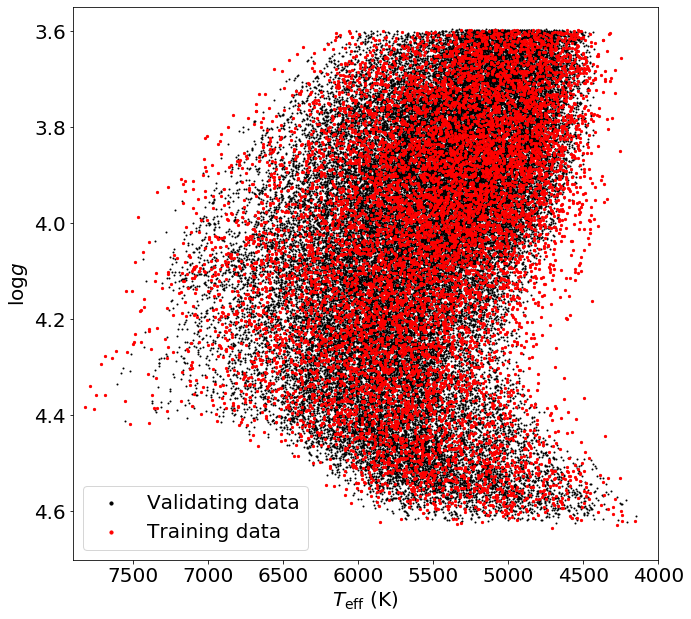

In [40]:
textsize = 20

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (11, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)

fig, ax = plt.subplots(1,1, figsize = (10,9))
#ax.scatter(dfvon['effective_T'], dfvon['log_g'], c = 'b',s = 1)
ax.scatter(dfv['effective_T'], dfv['log_g'], c = 'k',s = 1)
cp = ax.scatter(gdf0['effective_T'], gdf0['log_g'], c = 'r',s = 5) 


#ax.scatter(0, 0, c = 'b',s = 10, label = 'Testing data')
ax.scatter(0,0, c = 'k',s = 10, label = 'Validating data')
ax.scatter(0, 0, c = 'r',s = 10, label = 'Training data')


ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel(r'$\log g$')
ax.set_xlim([7900,4000])
ax.set_ylim([4.7,3.55])
ax.legend(fontsize = 20)

#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
fig.tight_layout()
fig.savefig(gmk._savepath + 'M0_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

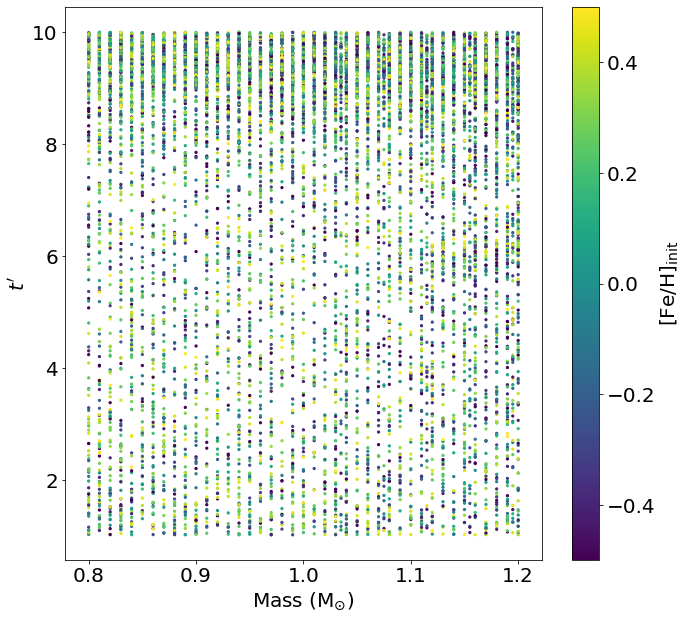

In [41]:
fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(gdf0['initial_mass'], gdf0['frac_age'], c = gdf0['initial_feh'],s = 5) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")


#cp = ax[1].scatter(gdf['initial_mass'], gdf['frac_age'], c = 'k',s = 10, label = 'Training data') #,cmap = 'hot')
#ax[1].scatter(dfv['initial_mass'], dfv['frac_age'], c = 'r',s = 10, label = 'Testing data') #,cmap = 'hot')
#ax[1].set_xlabel(r'$M/M_{\odot}$')
#ax[1].set_ylabel(r"$t'$")
cc = plt.colorbar(cp)
cc.set_label(r'[Fe/H]$_{\rm init}$')
fig.tight_layout()
fig.savefig(gmk._savepath + 'M0_data.pdf')
#ax1.set_title('MESA grid models')

In [42]:
# Train and validate
def train_and_validate(gdf, dfv, kname, label):
    print('training ' + label)
    gpm = gmk.gp_a_dataframe(df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)
    #
    np.save(gmk._savepath + label + '_gpm_.npy', gpm.param_array)
    gdf.to_csv(gmk._savepath + label + '_gpm_.csv')
    #    
    print('validating ...')
    gpp = dfv.copy()
    offsets = dfv.copy()
    gpp = gmk.sample_with_df(n = 1, df = dfv, gpm = gpm, 
                             xcolumns = xcolumns, xshift = xshifts, 
                             randomshift = False, ycolumns = ycolumns)
    gpp.to_csv(gmk._savepath + label + '_gpp_.csv')
    offsets[ycolumns] = dfv[ycolumns] - gpp[ycolumns]
    validations = np.percentile(np.abs(offsets[ycolumns[0]]), [50, 95, 99.8, 100])
    print('Model---50%----95%---99.8%---100%')
    print(label, validations)
    #
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets[ycolumns[0]],s = 10) 
    ax.set_xlabel(r'Mass (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    #ax.set_xlim([7000,4750])
    #ax.set_ylim([4.7,3.7])
    cc = plt.colorbar(cp)
    cc.set_label(ycolumns[0])
    ax.set_title(label)
    #ax.legend(fontsize = 20)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'validation.pdf')
    
    return gpm, gpp, offsets, validations

In [43]:
### Train model0
#kname = 'MLP'
#label = 'M0_' + kname 
#gpm0, gpp0, offsets0, validations0 = train_and_validate(gdf, dfv, kname, label)

In [44]:
### load model0
kname = 'MLP'
gdf0 = gdf0
npy = savedr + 'M0_MLP_gpm_.npy'
gpm0 = gmk.load_a_gpm(df = gdf0, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)
gpp0 = pd.read_csv(savedr + 'M0_MLP_gpp_.csv')
offsets0 = pd.read_csv(savedr + 'M0_MLP_offsets_.csv')
validations0 = np.percentile(np.abs(offsets0[ycolumns[0]]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations0)

 /opt/anaconda3/lib/python3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



Name : GP regression
Objective : 45928.36839173853
Number of Parameters : 8
Number of Optimization Parameters : 8
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  mlp.variance             |  145855.52137068595  |      +ve      |        
  mlp.weight_variance      |                (5,)  |      +ve      |        
  mlp.bias_variance        |  5658.5796025083855  |      +ve      |        
  Gaussian_noise.variance  |   27.14203715218965  |      +ve      |        
Model---50%----95%---99.8%---100%
[  2.63099581  18.69546135  93.81075276 207.92487142]


Model---50%----95%---99.8%---100%
[  2.63099581  18.69546135  93.81075276 207.92487142]


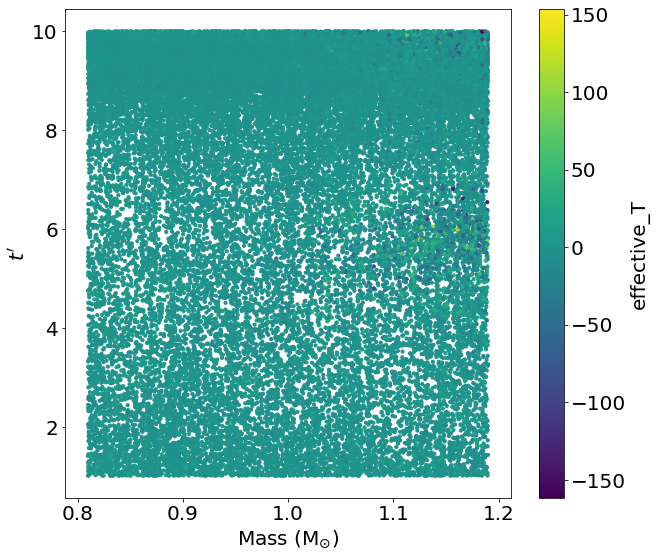

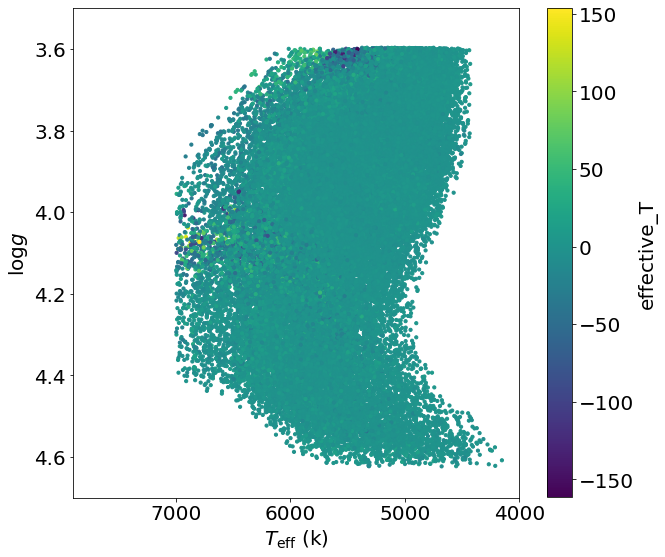

In [45]:
index = dfv['effective_T']<=10000

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv[index]['initial_mass'], 10**dfv[index]['frac_age'], c = offsets0[index][ycolumns[0]],s = 10)
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv[index]['effective_T'], dfv[index]['log_g'], c = offsets0[index][ycolumns[0]],s = 10)
ax.set_xlabel(r'$T_{\rm eff}$ (k)')
ax.set_ylabel(r"$\log g$")
ax.set_xlim([7900,4000])
ax.set_ylim([4.7,3.5])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

Text(0, 0.5, 'True Validation error')

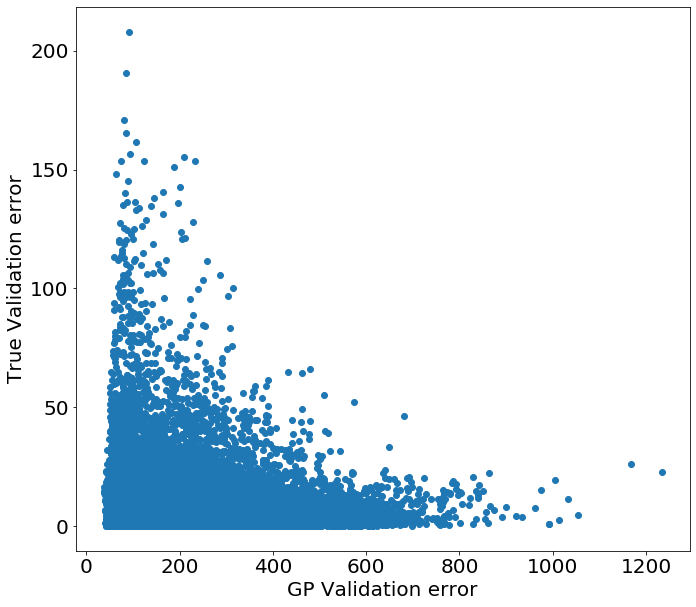

In [51]:
plt.scatter(gpp0['gp_var'], np.abs(offsets0[ycolumns[0]]))
plt.xlabel('GP Validation error')
plt.ylabel('True Validation error')

 # work on residuls (1-order)

In [ ]:
def make_training_data_for_residual(sdf, gpms, label):
    
    gpp = sdf.copy()
    gdfr = sdf.copy()
    
    for gpm in gpms:
        gpp = gmk.sample_with_df(n = 1, df = sdf, gpm = gpm, 
                                 xcolumns = xcolumns, xshift = xshifts, 
                                 randomshift = False, ycolumns = ycolumns)
        gdfr[ycolumns] = gdfr[ycolumns] - gpp[ycolumns]
    #    
    gdfr['weights'] = np.abs(gdfr[ycolumns])
    gdfr = gdfr.sample(n = ntraining, weights = 'weights', random_state = 99)
    gdfr.to_csv(gmk._savepath + label + '_gdfr_.csv')
    
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(gdfr['initial_mass'], gdfr['frac_age'], c = gdfr[ycolumns[0]],s = 10) 
    ax.set_xlabel(r'Mass')
    ax.set_ylabel(r"$t'$")
    cc = plt.colorbar(cp)
    cc.set_label(ycolumns[0])
    ax.set_title(label)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'.png')    
    return gdfr

In [ ]:
#sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 139)
#sdf.index = range(len(sdf))
#gpms = [gpm0]
#label = 'M1_data'
#gdf1 = make_training_data_for_residual(sdf, gpms, label)

In [ ]:
#knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
#for kname in knames:
#    label = 'M1_' + kname 
#    gpm1, gpp1, offsets1, validations1 = train_and_validate(gdf1, offsets0, kname, label)

In [ ]:
# the Mat32 kernel wins, so gmp1 kernel is 'mat32'
#kname = 'Mat32'
#label = 'M1_winner_' + kname
#gpm1, gpp1, offsets1, validations1 = train_and_validate(gdf1, offsets0, kname, label)

In [ ]:
kname = 'Mat32'
gdf1 = pd.read_csv(savedr + 'M1_winner_Mat32_gpm_.csv')
npy = savedr + 'M1_winner_Mat32_gpm_.npy'
gpm1 = gmk.load_a_gpm(df = gdf1, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)

offsets1 = dfv.copy()
gpp1 = pd.read_csv(savedr + 'M1_winner_Mat32_gpp_.csv')
offsets1[ycolumns] = offsets0[ycolumns] - gpp1[ycolumns]
offsets1.to_csv(savedr + 'M1_winner_Mat32_offsets_.csv')
validations1 = np.percentile(np.abs(offsets1[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations1)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets1[ycolumns[0]],s = 10) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

# 2nd-order residuals

In [ ]:
#sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 887)
#sdf.index = range(len(sdf))
#gpms = [gpm0,gpm1]
#label = 'M2_data'
#gdf2 = make_training_data_for_residual(sdf, gpms, label)

gdf2 = pd.read_csv(savedr + 'M2_data_gdfr_.csv')

In [ ]:
knames = ['MLP', 'EXP', 'RBF', 'RQ']
for kname in knames:
    label = 'M2_' + kname 
    gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)

In [ ]:
knames = ['Mat32']
for kname in knames:
    label = 'M2_' + kname 
    gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)

In [ ]:
# EXP wins
#kname = 'EXP'
#label = 'M2_winner' + kname 
#gpm2, gpp2, offsets2, validations2 = train_and_validate(gdf2, offsets1, kname, label)

In [ ]:
kname = 'EXP'
gdf2 = pd.read_csv(savedr + 'M2_winner_EXP_gpm_.csv')
npy = savedr + 'M2_winner_EXP_gpm_.npy'
gpm2 = gmk.load_a_gpm(df = gdf2, npy = npy, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)

offsets2 = dfv.copy()
gpp2 = pd.read_csv(savedr + 'M2_winner_EXP_gpp_.csv')
offsets2[ycolumns] = offsets1[ycolumns] - gpp2[ycolumns]
offsets2.to_csv(savedr + 'M2_winner_EXP_offsets_.csv')
validations2 = np.percentile(np.abs(offsets2[ycolumns]), [50, 95, 99.8, 100])
print('Model---50%----95%---99.8%---100%')
print(validations2)

fig, ax = plt.subplots(1,1, figsize = (10,9))
cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets2[ycolumns[0]],s = 10) 
ax.set_xlabel(r'Mass (M$_{\odot}$)')
ax.set_ylabel(r"$t'$")
#ax.set_xlim([7000,4750])
#ax.set_ylim([4.7,3.7])
cc = plt.colorbar(cp)
cc.set_label(ycolumns[0])
#ax.set_title(label)

# 3rd order residual.

In [ ]:
sdf = df.sample(n = nresidual, weights = 'hrgradient', random_state = 608)
sdf.index = range(len(sdf))
gpms = [gpm0,gpm1,gpm2]
label = 'M3_data'
gdf3 = make_training_data_for_residual(sdf, gpms, label)

In [ ]:
knames = ['MLP', 'EXP', 'RBF', 'RQ', 'Mat32']
for kname in knames:
    label = 'M3_' + kname
    gpm3 = gpp3 = offsets3 = validations3 = None
    gpm3, gpp3, offsets3, validations3 = train_and_validate(gdf3, offsets2, kname, label)

In [ ]:
# RBF wins

validations3 = np.array([1.55112935,  8.89029012, 39.11138394, 68.60200132])

In [ ]:
px = np.array([0,1,2,3])
pv_off = np.array([validations0, validations1, validations2, validations3])
pv_off

plt.scatter(px, pv_off[:,0],s = 100,facecolors='k', edgecolors='k',label = 'Cumulative value(50%)')
plt.scatter(px, pv_off[:,1],s = 100,facecolors='b', edgecolors='b',label = 'Cumulative value(95%)')
plt.scatter(px, pv_off[:,2],s = 100,facecolors='r', edgecolors='r',label = 'Cumulative value(99.8%)')
plt.scatter(px, pv_off[:,3],s = 100,facecolors='g', edgecolors='g',label = 'Maximum value')


plt.yscale('linear')
plt.xticks([0,1,2,3], ('M0', 'M1', 'M2', 'M3'))
plt.ylim([-0.00,150])
plt.title('Validations for the Data-Residual Process')
plt.ylabel(r'ABS($T_{\rm eff, True}$ - $T_{\rm eff, GP}$) (K)')
plt.legend()